In this assignment, we will attempt to stitch a series of low contrast images by optimizing our image registration steps. We will be using SIFT and a Flann matcher to conduct the registration and then optimize the findings using GTSAM.

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from math import ceil
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform
from scipy.optimize import least_squares
import gtsam
import itertools
import gtsam.utils.plot

First we will read in all the images.

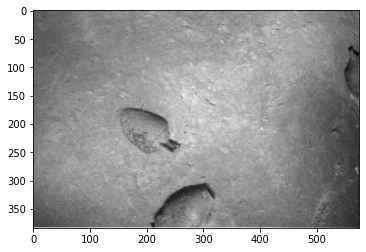

In [38]:
img1 = cv2.imread('6images/1.tif')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('6images/2.tif')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread('6images/3.tif')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread('6images/4.tif')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread('6images/5.tif')
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.imread('6images/6.tif')
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()

imgs = [img1, img2, img3, img4, img5, img6]

We will now normalize each image using minmax.

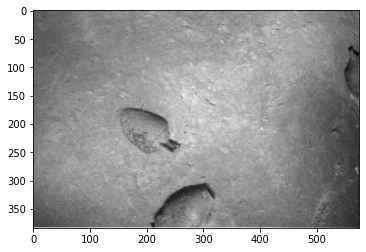

In [39]:
# Normalize images
height, width, channels = img1.shape
norms_img = np.zeros([height, width])
norm_imgs = imgs
for i in range(len(imgs)):
   norm_imgs[i] = cv2.normalize(imgs[i], norms_img, 0, 255, cv2.NORM_MINMAX)

plt.imshow(imgs[0])
plt.show()

In [40]:
# Define which method to use to compute features and keypoints
def get_descriptor(img, method=None):
    if method == 'sift':
        descriptor = cv2.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.5)
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    
    (keypoints, features) = descriptor.detectAndCompute(img, None)
    return keypoints, features

We find all the keypoints and features for each image.

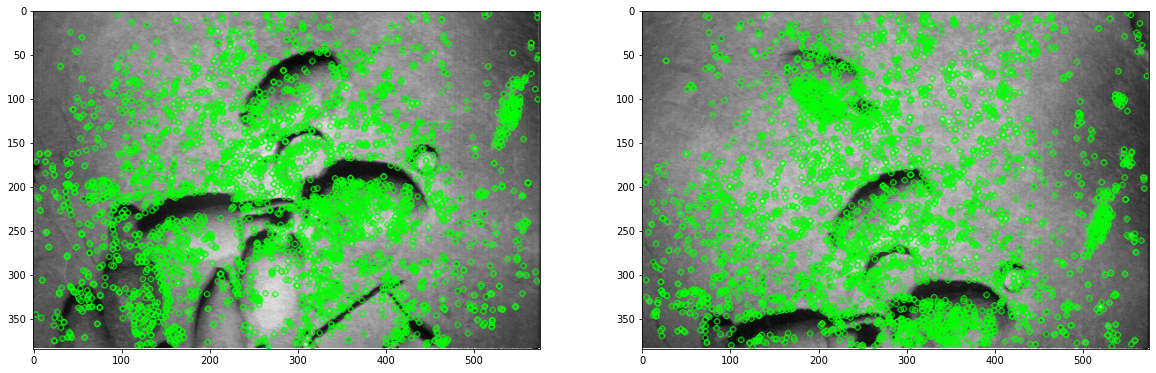

In [41]:
kps_img3, feat_img3 = get_descriptor(imgs[2], method='sift')
kps_img2, feat_img2 = get_descriptor(imgs[1], method='sift')
kps_img4, feat_img4 = get_descriptor(imgs[3], method='sift')
kps_img1, feat_img1 = get_descriptor(imgs[0], method='sift')
kps_img5, feat_img5 = get_descriptor(imgs[4], method='sift')
kps_img6, feat_img6 = get_descriptor(imgs[5], method='sift')

kps = [kps_img1, kps_img2, kps_img3, kps_img4, kps_img5, kps_img6]
feat = [feat_img1, feat_img2, feat_img3, feat_img4, feat_img5, feat_img6]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(cv2.drawKeypoints(img3, kps_img3, None, color=(0,255,0)))
ax2.imshow(cv2.drawKeypoints(img2, kps_img2, None, color=(0,255,0)))
plt.show()

In [42]:
print(len(kps_img6))

4000


Now we define our function to obtain all of our matches and keypoints given the images. This way we can perform image registartion on any set of images like between 2-5 and 3-6.

In [43]:
def match_keypoints(image_one, image_two, show_result = False):
    
    kps_img_one, feat_img_one = get_descriptor(image_one, 'sift') # getting keypoints, and descriptors for source img 
    kps_img_two, feat_img_two = get_descriptor(image_two, 'sift') # getting keypoints, and descriptors for destn img

    # Flann based matcher
    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(feat_img_one, feat_img_two,k=2)

    img_one_pts = []
    img_two_pts = []
    good = []

    # Use Lowe's ratio test and append the points that qualify
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append([m])
            img_one_pts.append(kps_img_one[m.queryIdx].pt)
            img_two_pts.append(kps_img_two[m.trainIdx].pt)
            
    if show_result:
        img3 = cv2.drawMatchesKnn(image_one,kps_img_one,image_two,kps_img_two, good[:50], None,
                              matchColor=(0, 255, 0), matchesMask=None,
                              singlePointColor=(255, 0, 0), flags=0)
        plt.figure(figsize=(20,8))
        plt.imshow(img3)
        plt.show()
    
    return np.array(img_one_pts), np.array(img_two_pts)

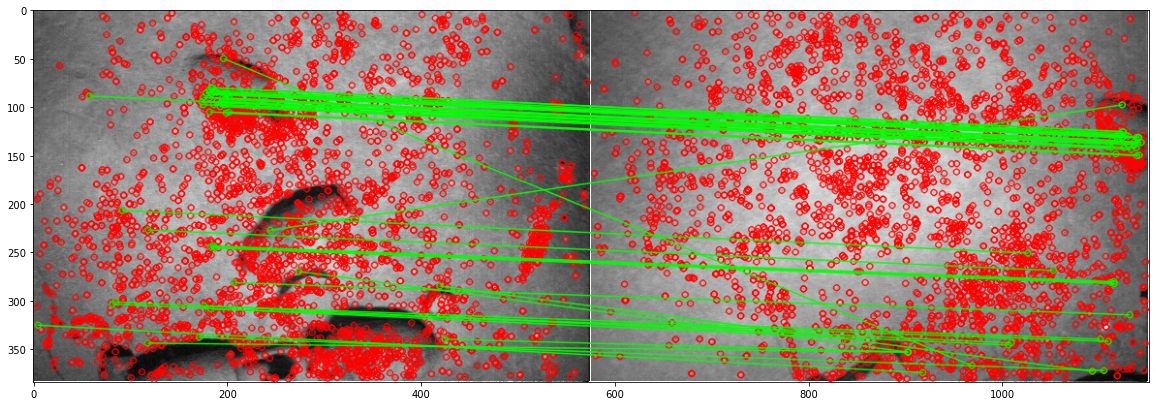

In [44]:
matches = match_keypoints(imgs[1], imgs[5], show_result=True) # Matched points betwen image 2 and image 5

## GTSAM 

We now define all the functions necessary to build our factor graph. First is the affine noise which incorporates RANSAC on the keypoints to obtain our noise model and affine transformation. Then we define getting the pose from that affine matrix and define our overlap between various images. Finally we build the factor graph from each of these pieces and plot the poses obtained from the graph with each of the convariances. 

In [45]:
# Taken from ZZ
def get_affine_noise(src, dst):
  if len(src) < 4:
    return None

  affine_mat, ransac_mask = cv2.estimateAffinePartial2D(src, dst)

  match_count = np.count_nonzero(ransac_mask)
  
  if match_count < 3:
    return None

  scale = np.sqrt(affine_mat[0, 0]**2 + affine_mat[1, 0]**2)
  affine_mat[:2, :2] /= scale

  diag_noise = 1000*match_count**-2*np.array([1, 1, np.deg2rad(1)])

  gtsam_noise = gtsam.noiseModel.Diagonal.Sigmas(diag_noise)

  return np.linalg.inv(np.vstack((affine_mat, [0, 0, 1]))), gtsam_noise

In [46]:
# Find pose from affine noise
def get_gtsam_pose2(affine_matrix):
  return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1], np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))

In [47]:
# Check to see if there is overlap where the euclidean distance is less than 80% of the image width
def check_overlap(pose_1, pose_2):
    return cv2.norm(pose_1.translation()-pose_2.translation()) < width*.8

In [48]:
# Build the factor graph given initial pose values and the images, taken from ZZ with some edits
def build_graph(values, images):

  # Initialize factor graph
  graph = gtsam.NonlinearFactorGraph()

  graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(width/2, height/2, 0), prior_noise)) # defining prior pose, noise  

  for src_index, dst_index in itertools.combinations(range(len(images)), 2):
    if src_index + 1 == dst_index: # for every subsequent images, add factors between imgs
      
      src_points, des_points = match_keypoints(images[src_index], images[dst_index])

      affine_matrix_noise = get_affine_noise(src_points, des_points)

      graph.add(gtsam.BetweenFactorPose2(src_index, dst_index, get_gtsam_pose2(affine_matrix_noise[0]), affine_matrix_noise[1])) 

    elif check_overlap(values.atPose2(src_index), values.atPose2(dst_index)): # If overlap, add the pose to the factor graph only if the affine matrix noise exists
      
      src_points, des_points = match_keypoints(images[src_index], images[dst_index])

      affine_matrix_noise = get_affine_noise(src_points, des_points)

      if affine_matrix_noise is not None: # if affine matrix is not empty, adding factor b/w poses
          graph.add(gtsam.BetweenFactorPose2(src_index, dst_index, get_gtsam_pose2(affine_matrix_noise[0]), affine_matrix_noise[1]))
  
  return graph

In [49]:
# Plot edges and vertices of each image with its covariance
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()): # For each vertex, plot the 2D pose with its covariance
        gtsam.utils.plot.plot_pose2(0, values.atPose2(vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]: # For each edge, get the keys and plot the start and end pose at those keys
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

Now that all the functions are written, we will now try to obtain initial guesses for each image pair through the affine matrix transforms between each image pair.

In [50]:
# Diagonal covariance matrix of x, y, and radians of yaw
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([5, 5, np.deg2rad(5)]))

# Constructor of Values class
initial_values = gtsam.Values()

img_width = norm_imgs[0].shape[1]
img_height = norm_imgs[0].shape[0]

total_affine_matrix = np.eye(3) # initialize affine matrix

initial_values.insert(0, gtsam.Pose2())

for src_index in range(len(norm_imgs)-1):

    dst_index = src_index + 1

    src_points, des_points = match_keypoints(norm_imgs[src_index], norm_imgs[dst_index])

    affine_matrix, gtsam_noise = get_affine_noise(src_points, des_points)

    total_affine_matrix = affine_matrix.dot(total_affine_matrix)

    initial_values.insert(dst_index, get_gtsam_pose2(total_affine_matrix))

We will take those initial values and the normalized images and build the Factor Graph without the optimization first.

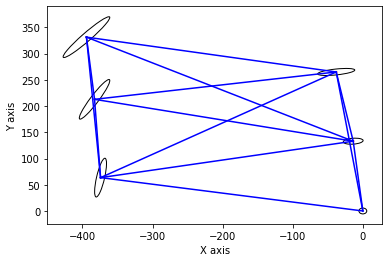

In [51]:
graph = build_graph(initial_values, norm_imgs)
marginals = gtsam.Marginals(graph, initial_values)
plot_graph(initial_values, graph, marginals)

We will now look at the factor graph built by optimizing using Levenberg-Marquadt.

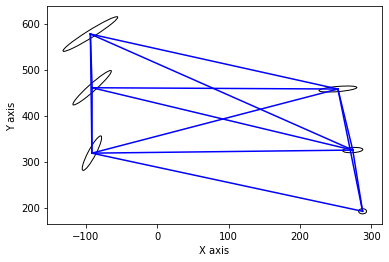

In [52]:
graph = build_graph(initial_values, norm_imgs)
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

The optimized factor graph has noticeable differences in the covariances and the shift between points. What was the (0,0) point in the unoptimized factor graph is the (290,200) point and the (0,0) is shifted downward and to the left.

Using the Factor graph produced, we will create the affine_matrix list made up of the affine_matrix and translation matrix. Finally, we will stitch the images together.

In [53]:
poses = gtsam.utilities.allPose2s(initial)

affine_matrix_list = []

for index in range(len(norm_imgs)):

    pose = poses.atPose2(index) # Get the pose of each image

    affine_matrix = pose.matrix() # create matrix from the pose

    translation_matrix = np.eye(3) # H_0

    translation_matrix[:2, 2] -= np.array([img_width/2, img_height/2]).T # offset the translation matrix by the center of the image

    affine_matrix_list.append(affine_matrix@translation_matrix) # add the matrices to a matrix list

In [54]:
# Taken from Sushant Govindraj because I couldn't get my stitch function working properly, I also made some edits to this. This fails if size of the stitch exceeds the size of the panorama
def stitch(images, updated_homographies, panorama_size = (4096, 4096)):

  blank = np.zeros((panorama_size[0], panorama_size[1], 3), np.uint8)
  translation = np.array([[1,0,panorama_size[0]/2], [0,1,panorama_size[1]/2], [0,0,1]]) # translation matrix 

  for i in range(len(images)): # go through image set
      temp = cv2.warpPerspective(images[i], np.matmul(translation, updated_homographies[i]), panorama_size) # current image warped + translated onto final panaroma
      blank = np.maximum(blank, temp) # growing/final pan by simple addition and using max pixel intensity

  mask = np.sum(blank, axis=2).astype(bool) # sum the elements along axis 2 and convert to bool

  # Finding appropriate bounding box
  yy, xx = np.where(mask == 1)
  x_min, x_max = np.min(xx), np.max(xx)
  y_min, y_max = np.min(yy), np.max(yy)

  # Crop and save
  stitch = blank[y_min:y_max, x_min:x_max]
  
  return stitch

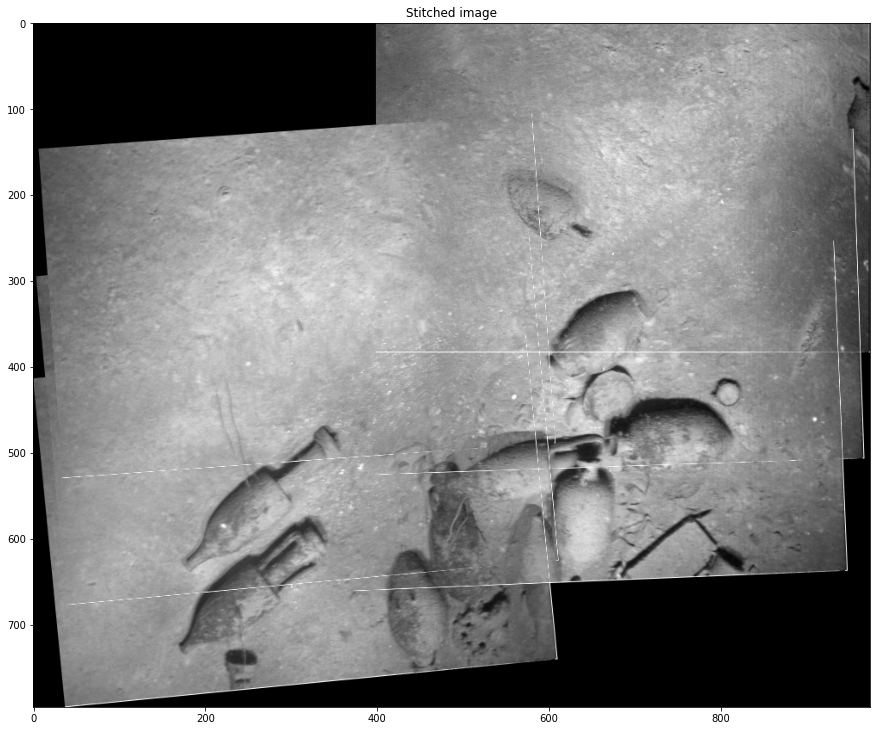

In [55]:
img = stitch(norm_imgs, affine_matrix_list)
plt.figure(figsize = (15, 15))
plt.imshow(img)
plt.title('Stitched image')
plt.show()

These images stitched pretty well. There is some small error between the 2 top images on the left but otherwise, most of the other images lined up fairly well.